<a href="https://colab.research.google.com/github/JoshOmondi/deep_learning/blob/master/fer2013_emotion_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()


Saving kaggle (4).json to kaggle (4).json


{'kaggle (4).json': b'{"username":"joshua10542","key":"9fffd7b7fe520bd62b209c4364f3fde8"}'}

In [8]:
!mkdir -p ~/.kaggle
!cp "kaggle (4).json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json


In [9]:
!kaggle datasets list -s fer2013


ref                                                           title                                                    size  lastUpdated                 downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  -------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
deadskull7/fer2013                                            fer2013                                             101279992  2018-05-26 12:18:24.933000          57043        536  0.29411766       
nicolejyt/facialexpressionrecognition                         FER2013                                             101279992  2019-04-02 18:29:26.050000          10951         57  0.3529412        
astraszab/facial-expression-dataset-image-folders-fer2013     Facial expression dataset image folders (fer2013)    68268497  2020-04-14 08:15:32.013000           4905         66  0.5625           
subhaditya/fer2

In [11]:
!kaggle datasets download -d msambare/fer2013
!unzip -q fer2013.zip -d fer2013


Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
fer2013.zip: Skipping, found more recently modified local copy (use --force to force download)
replace fer2013/test/angry/PrivateTest_10131363.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import numpy as np
import os
import gradio as gr


In [13]:
# Parameters
img_size = 48
batch_size = 32
num_classes = 7

datagen_args = dict(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)


In [14]:
train_dir = "/content/fer2013/train"

# Image Generators
train_datagen = ImageDataGenerator(**datagen_args)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.


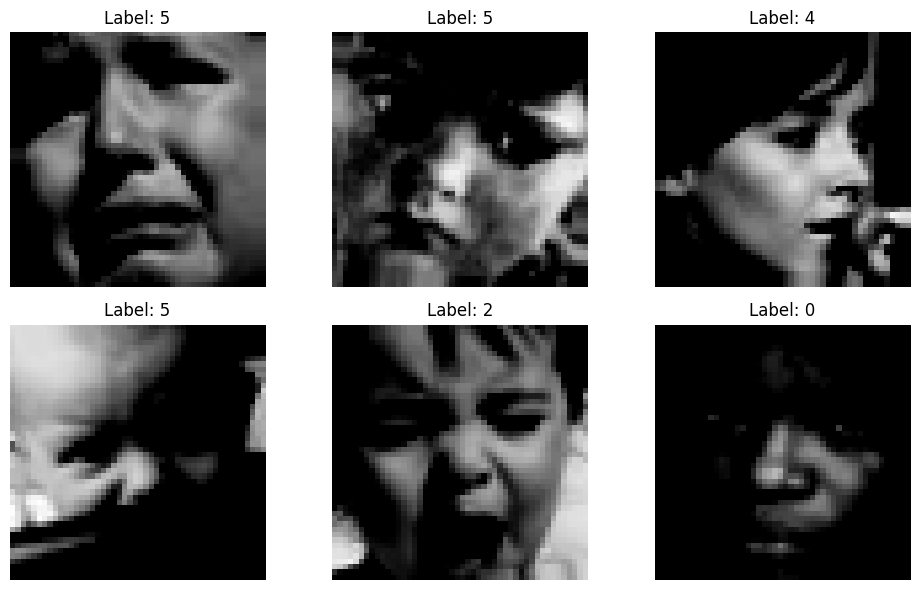

In [16]:
# Get one batch of augmented images
images, labels = next(train_gen)

# Plot first 6 images
plt.figure(figsize=(10, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[i])
    plt.title(f"Label: {labels[i].argmax()}")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [17]:
# Build Model
base_model = MobileNetV2(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet')
base_model.trainable = False

inputs = Input(shape=(img_size, img_size, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs, outputs)


/tmp/ipython-input-17-4096520763.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet')


In [18]:
# Compile and Train
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_gen, validation_data=val_gen, epochs=30)


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


718/718 ━━━━━━━━━━━━━━━━━━━━ 50s 56ms/step - accuracy: 0.2792 - loss: 2.0336 - val_accuracy: 0.3799 - val_loss: 1.6490
Epoch 2/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 31s 43ms/step - accuracy: 0.3473 - loss: 1.6951 - val_accuracy: 0.3829 - val_loss: 1.6288
Epoch 3/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 42s 44ms/step - accuracy: 0.3677 - loss: 1.6533 - val_accuracy: 0.3714 - val_loss: 1.6489
Epoch 4/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 31s 43ms/step - accuracy: 0.3632 - loss: 1.6578 - val_accuracy: 0.3590 - val_loss: 1.6749
Epoch 5/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.3699 - loss: 1.6448 - val_accuracy: 0.3792 - val_loss: 1.6196
Epoch 6/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 34s 47ms/step - accuracy: 0.3660 - loss: 1.6458 - val_accuracy: 0.3860 - val_loss: 1.6160
Epoch 7/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 34s 47ms/step - accuracy: 0.3670 - loss: 1.6352 - val_accuracy: 0.3729 - val_loss: 1.6232
Epoch 8/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 40s 46ms/step - accuracy: 0.3654 - loss: 1.6431 - val_accurac

In [19]:
loss, accuracy = model.evaluate(val_gen)
print(f"Validation Accuracy: {accuracy:.2f}")


180/180 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.2914 - loss: 1.7874
Validation Accuracy: 0.38


In [20]:
# Save Model
model.save("emotion_model.h5")

In [21]:
# Gradio UI
dict_classes = list(train_gen.class_indices.keys())

def predict_emotion(img):
    import numpy as np
    from tensorflow.keras.preprocessing.image import img_to_array

    img = img.resize((img_size, img_size)).convert("RGB")
    img_array = img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    label = dict_classes[tf.argmax(predictions[0])]
    return f"Predicted Emotion: {label}"

interface = gr.Interface(fn=predict_emotion,
                         inputs=gr.Image(type="pil"),
                         outputs="text",
                         title="Facial Emotion Recognition",
                         description="Upload a face image to detect emotion.")

interface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ef1b9fc9e5f430f897.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
